In [1]:
# from elementos_matriz import *
from elementos_matriz import *
import matplotlib.pyplot as plt

from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
# estimator
from qiskit.primitives import Estimator
# ansatz
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
# optimizers
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
# VQE
from qiskit_algorithms import VQE

In [2]:
def elementos_matriz(d, a, RA, RB, ZA, ZB):
    # elementos de un cuerpo
    f11 = fpp(1, d, a, RA, RB, ZA, ZB)
    f33 = fpp(3, d, a, RA, RB, ZA, ZB)
    # elementos de dos cuerpos
    g1212 = gpqrs([1,2,1,2], d, a, RA, RB)
    g3434 = gpqrs([3,4,3,4], d, a, RA, RB)
    g1313 = gpqrs([1,3,1,3], d, a, RA, RB)
    g1331 = gpqrs([1,3,3,1], d, a, RA, RB)

    return f11, f33, g1212, g3434, g1313, g1331

In [47]:
def energia_clasica(d, a, RA, RB, ZA, ZB):
    f11, f33, g1212, g3434, g1313, g1331 = elementos_matriz(d, a, RA, RB, ZA, ZB)
    hnuc = 1/(np.linalg.norm(RA-RB))
    E0 = 2*f11 + g1212
    Etot = E0 + hnuc
    return Etot

In [3]:
def hamiltoniano_H2(d, a, RA, RB, ZA, ZB):
    f11, f33, g1212, g3434, g1313, g1331 = elementos_matriz(d, a, RA, RB, ZA, ZB) # elementos de matriz
    h12 = (2*f11 + g1212 + 2*g1313 - g1331)/4
    h34 = (2*f33 + g3434 + 2*g1313 - g1331)/4
    h0 = f11 + f33 + g1212/4 + g3434/4 + g1313 - g1331/2
    
    # hamiltonian = SparsePauliOp.from_list(
    #     [
    #         ("IIII", h0),
    #         ("IIIZ", -h12),
    #         ("IIZI", -h12),
    #         ("IZII", -h34),
    #         ("ZIII", -h34),
    #         ("IIZZ", g1212/4),
    #         ("ZZII", g3434/4),
    #         ("ZIIZ", g1313/4),
    #         ("IZZI", g1313/4),
    #         ("IZIZ", (g1313-g1331)/4),
    #         ("ZIZI", (g1313-g1331)/4),
    #         ("YYYY", g1331/4),
    #         ("XXYY", g1331/4),
    #         ("YYXX", g1331/4),
    #         ("XXXX", g1331/4),
    #     ]
    # )
    hamiltonian = SparsePauliOp.from_list(
        [
            ("IIII", h0),
            ("IIIZ", -h12),
            ("IZII", -h12),
            ("IIZI", -h34),
            ("ZIII", -h34),
            ("IZIZ", g1212/4),
            ("IIZZ", (g1313-g1331)/4),
            ("ZZII", (g1313-g1331)/4),
            ("ZIIZ", g1313/4),
            ("YYYY", g1331/4),
            ("XXYY", g1331/4),
            ("YYXX", g1331/4),
            ("XXXX", g1331/4),
            ("IZZI", g1313/4),
            ("ZIZI", g3434/4),
        ]
    )
    return hamiltonian

In [4]:
f11, f33, g1212, g3434, g1313, g1331 = elementos_matriz(d, a, RA, RB, ZA, ZB) # elementos de matriz
f11, f33, g1212, g3434, g1313, g1331

(np.float64(-1.252468234996496),
 np.float64(-0.47581972486855656),
 np.float64(0.6754975368615006),
 np.float64(0.72117995019135),
 np.float64(0.6586028733416299),
 np.float64(0.18129744028439126))

In [5]:
num_spatial_orbitals = 2
num_particles = (1,1)
qubit_mapper = JordanWignerMapper()

---
---
---

In [6]:
hamiltonian = hamiltoniano_H2(d, a, RA, RB, ZA, ZB)
hamiltonian

SparsePauliOp(['IIII', 'IIIZ', 'IZII', 'IIZI', 'ZIII', 'IZIZ', 'IIZZ', 'ZZII', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI'],
              coeffs=[-0.81116443+0.j,  0.17338266+0.j,  0.17338266+0.j, -0.2263622 +0.j,
 -0.2263622 +0.j,  0.16887438+0.j,  0.11932636+0.j,  0.11932636+0.j,
  0.16465072+0.j,  0.04532436+0.j,  0.04532436+0.j,  0.04532436+0.j,
  0.04532436+0.j,  0.16465072+0.j,  0.18029499+0.j])

In [7]:
### Initial state
init_state = HartreeFock(num_spatial_orbitals, num_particles, qubit_mapper)
init_state.draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────

In [8]:
### Estimator
estimator = Estimator()
estimator

C:\Users\rodri\AppData\Local\Temp\ipykernel_20436\2581567160.py:2: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()


In [9]:
### Ansatz
ansatz = UCCSD(num_spatial_orbitals, num_particles, qubit_mapper, initial_state=init_state)
ansatz.draw()

┌─────────────────────────────┐
q_0: ┤0                            ├
     │                             │
q_1: ┤1                            ├
     │  EvolvedOps(t[0],t[1],t[2]) │
q_2: ┤2                            ├
     │                             │
q_3: ┤3                            ├
     └─────────────────────────────┘

In [10]:
### Optimizer
optimizer = SLSQP(maxiter=10)
optimizer

In [11]:
vqe = VQE(estimator, ansatz, optimizer, initial_point=[0]*ansatz.num_parameters)
vqe

In [12]:
vqe_calc = vqe.compute_minimum_eigenvalue(hamiltonian)
vqe_calc.eigenvalue

np.float64(-1.8497373408043871)

---
---
---

In [14]:
distancias = np.arange(0.35, 7.6, 0.3)
vqe_energies = []
total = len(distancias)

for i in range(total):
    if (i+1)*100/total % 10 == 0:
        print(f"{(i+1)*100/total}% de casos calculados.")
    
    RB = np.array([distancias[i], 0, 0])
    qubit_op = hamiltoniano_H2(d, a, RA, RB, ZA, ZB)
    hnuc = 1/(np.linalg.norm(RA-RB))

    # Valores iniciales
    init_state = HartreeFock(num_spatial_orbitals, num_particles, qubit_mapper)

    ### Ansatz
    ansatz = UCCSD(num_spatial_orbitals, num_particles, qubit_mapper, initial_state=init_state)

    vqe = VQE(estimator, ansatz, optimizer, initial_point=[0]*ansatz.num_parameters)

    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_energies.append(vqe_calc.eigenvalue + hnuc)

print(f"Las energías para las {total} distancias han sido calculadas.")

20.0% de casos calculados.
40.0% de casos calculados.
60.0% de casos calculados.
80.0% de casos calculados.
100.0% de casos calculados.
Las energías para las 25 distancias han sido calculadas.


In [49]:
distancias = np.arange(0.35, 7.6, 0.3)
classic_energies = []
total = len(distancias)

for i in range(total):
    if (i+1)*100/total % 10 == 0:
        print(f"{(i+1)*100/total}% de casos calculados.")

    RB = np.array([distancias[i], 0, 0])
    classic_energies.append(energia_clasica(d, a, RA, RB, ZA, ZB))

20.0% de casos calculados.
40.0% de casos calculados.
60.0% de casos calculados.
80.0% de casos calculados.
100.0% de casos calculados.


In [21]:
x_Kandala = np.array([0.204,0.299,0.401,0.591,0.73,0.985,1.19,1.387,1.577,1.788,1.978,2.985,3.974])
y_Kandala = np.array([0.194,-0.536,-0.848,-1.076,-1.109,-1.061,-1.039,-1.006,-0.979,-0.921,-0.936,-0.924,-0.927])

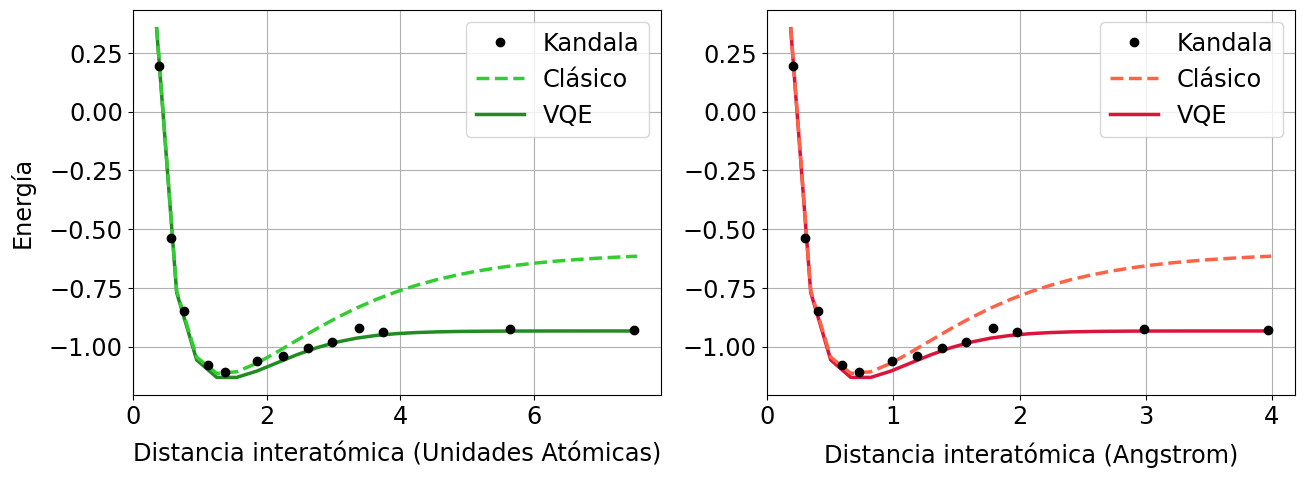

In [109]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

vqe0, = axs[0].plot(distancias, vqe_energies, label="VQE", linewidth=2.5, color='forestgreen')
classic0, = axs[0].plot(distancias, classic_energies, label="Clásico", linestyle='--', linewidth=2.5, color='limegreen')
kandala0, = axs[0].plot(x_Kandala/0.529177249, y_Kandala, label="Kandala", linestyle='None', linewidth=None, marker='o', color='black')
axs[0].set_xlabel("Distancia interatómica (Unidades Atómicas)", fontsize='xx-large', labelpad=10)
axs[0].set_ylabel("Energía", fontsize='xx-large', labelpad=10)

axs[1].plot(distancias*0.529177249, vqe_energies, label="VQE", linewidth=2.5, color='crimson')
axs[1].plot(distancias*0.529177249, classic_energies, label="Clásico", linestyle='--', linewidth=2.5, color='tomato')
axs[1].plot(x_Kandala, y_Kandala, label="Kandala", linestyle='None', linewidth=None, marker='o', color='black')
axs[1].set_xlabel("Distancia interatómica (Angstrom)", fontsize='xx-large', labelpad=10)

order = [2,1,0]
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], fontsize='xx-large', loc='upper right')
    ax.tick_params(axis='both', which='major', labelsize='xx-large')
    ax.grid()

nombre = 'VQE'
fig.subplots_adjust(wspace=0.2) # espacio entre figuras
plt.savefig(f"imgs/{nombre}.svg", format="svg")
plt.show()